In [22]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from statsmodels.tsa.statespace.sarimax import SARIMAX  # type: ignore[import-untyped]

In [23]:
SIGHTINGS_EXPORT = "sightings_2025-12-01T20_51_28.694624+00_00.json"
FUTURE_DAYS = 90
MAX_YEARS = 1

In [24]:
try:
    with open(SIGHTINGS_EXPORT, "r", encoding="utf-8") as f:
        sightings = json.load(f)
    print(f"Successfully loaded {len(sightings)} sightings from {SIGHTINGS_EXPORT}.")
except FileNotFoundError:
    print(f"Error: File not found at '{SIGHTINGS_EXPORT}'.")
    sightings = []

if not isinstance(sightings, list):
    raise ValueError("The exported JSON must contain a list of sightings.")

# display(sightings[:3])

Successfully loaded 165201 sightings from sightings_2025-12-01T20_51_28.694624+00_00.json.


In [25]:
df = pd.DataFrame(sightings)
required_cols = ["source", "creation_timestamp"]
missing_cols = [c for c in required_cols if c not in df.columns]
if missing_cols:
    raise ValueError(f"Missing required fields: {missing_cols}")

# Filter out null source
df = df[df["source"].notna()]

# Parse timestamps
df["creation_ts"] = pd.to_datetime(df["creation_timestamp"], utc=True, errors="coerce")

# Drop missing/invalid timestamps
df = df.dropna(subset=["creation_ts"])

# Filter out old sightings
cutoff = pd.Timestamp.now(tz="UTC") - pd.DateOffset(years=MAX_YEARS)
df = df[df["creation_ts"] >= cutoff]

# Aggregate
daily_counts = df.groupby(df["creation_ts"].dt.floor("D")).size().rename("sightings")

daily_series = daily_counts.asfreq("D", fill_value=0).sort_index()
daily_series.index.name = "date"
print(f"Data from {daily_series.index.min().date()} to {daily_series.index.max().date()} — {daily_series.sum()} sightings kept.")
daily_series_log = np.log1p(daily_series)

Data from 2024-12-02 to 2025-12-01 — 146764 sightings kept.


In [26]:
model = SARIMAX(daily_series_log, order=(1,1,1), enforce_stationarity=False, enforce_invertibility=False)
results = model.fit(disp=False)
forecast_log = results.get_forecast(steps=FUTURE_DAYS)
pred_mean_log = forecast_log.predicted_mean
conf_int_log = forecast_log.conf_int()
pred_mean = np.expm1(pred_mean_log)
conf_int = np.expm1(conf_int_log)

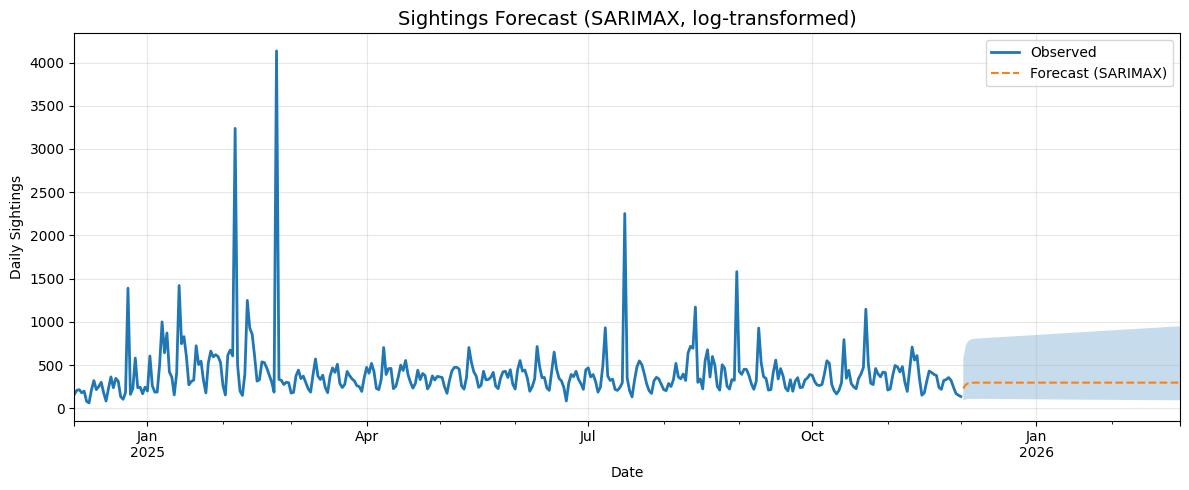

In [27]:
plt.figure(figsize=(12,5))
daily_series.plot(label="Observed", linewidth=2)
pred_mean.plot(label="Forecast (SARIMAX)", linestyle="--")
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], alpha=0.25)
plt.title("Sightings Forecast (SARIMAX, log-transformed)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Daily Sightings")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Trend slope: -0.198
Selected model: decay


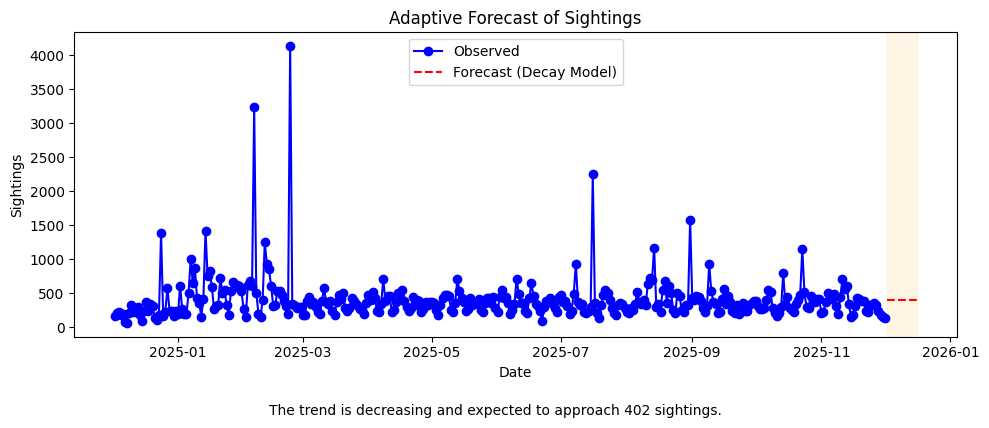

In [28]:
# --- Adaptive ---
def logistic(t, L, k, t0):
    return L / (1 + np.exp(-k*(t - t0)))
def exp_decay(t, a, b, c):
    return a * np.exp(-b * t) + c

t = np.arange(len(daily_series))
y = daily_series.values
if len(y) < 3:
    print("⚠️ Not enough data points for logistic/decay modeling.")
else:
    trend_slope = np.polyfit(t, y, 1)[0]
    print(f"Trend slope: {trend_slope:.3f}")
    model_type = "logistic" if trend_slope>0 else "decay"
    print(f"Selected model: {model_type}")
    try:
        if model_type == "logistic":
            L0 = max(y)*1.5; k0=0.3; t0=np.median(t)
            popt,_ = curve_fit(logistic, t, y, p0=[L0,k0,t0], bounds=([0,0,0],[np.inf,np.inf,np.inf]), maxfev=10000)
            forecast_func = lambda tt: logistic(tt,*popt)
        else:
            a0 = max(y); b0=0.3; c0 = min(y)
            popt,_ = curve_fit(exp_decay, t, y, p0=[a0,b0,c0], bounds=([0,0,0],[np.inf,np.inf,np.inf]), maxfev=10000)
            forecast_func = lambda tt: exp_decay(tt,*popt)
    except RuntimeError:
        print("⚠️ Curve fitting failed.")
        popt = None
    if popt is not None:
        future_steps = 15
        last_date = daily_series.index.max()
        forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps, freq="D")
        t_future = np.arange(len(daily_series), len(daily_series)+future_steps)
        forecast_values = np.maximum(forecast_func(t_future),0)
        plt.figure(figsize=(10,4))
        plt.plot(daily_series.index, daily_series.values, "bo-", label="Observed")
        plt.plot(forecast_dates, forecast_values, "r--", label=f"Forecast ({model_type.capitalize()} Model)")
        plt.axvspan(forecast_dates[0], forecast_dates[-1], color="orange", alpha=0.1)
        plt.title("Adaptive Forecast of Sightings")
        plt.xlabel("Date")
        plt.ylabel("Sightings")
        plt.legend()
        if model_type == "logistic":
            summary = f"The trend is rising and expected to plateau around {popt[0]:.0f} sightings."
        else:
            summary = f"The trend is decreasing and expected to approach {popt[2]:.0f} sightings."
        plt.figtext(0.5, -0.05, summary, ha="center", fontsize=10, color="black")
        plt.tight_layout()
        plt.show()